<img src="https://github.com/dc-aihub/dc-aihub.github.io/blob/master/img/ai-logo-transparent-banner.png?raw=true" 
alt="Ai/Hub Logo"/>

<h1 style="text-align:center;color:#0B8261;"><center>TensorFlow</center></h1>
<h1 style="text-align:center;"><center>Lesson 4</center></h1>
<h1 style="text-align:center;"><center>Save and Restore</center></h1>

<hr />

<center><a href="#Flowchart">Flowchart</a></center>

<center><a href="#Prep-and-Process">Preparation and Pre-Processing</a></center>

<center><a href="#Convolutional-Neural-Net">Convolutional Neural Network</a></center>

<center><a href="#Getting-Weights">Getting Weights</a></center>

<center><a href="#Optimization-Method">Optimization Method</a></center>

<center><a href="#Performance-Measures">Performance Measures</a></center>

<center><a href="#Saver">Saver</a></center>

<center><a href="#TensorFlow-Run">TensorFlow Run</a></center>

<center><a href="#Performance-over-Optimizations">Performance over Optimizations</a></center>

<center><a href="#Initialize-Variables-Again">Re-Intialize Variables</a></center>

<center><a href="#Restore-Best-Variables">Restore Best Variables</a></center>

<center><a href="#Summary">Summary</a></center>

<center><a href="#Challenge">Challenge</a></center>

<hr />

<center>***Original Tutorial by Magnus Erik Hvass Pedersen:*** <br/>https://github.com/Hvass-Labs/TensorFlow-Tutorials</center>

<div style="background-color:#0B8261; width:100%; height:38px; color:white; font-size:18px; padding:10px;">
OVERVIEW
</div>

<center style="color:#0B8261;">
This tutorial demonstrates how to save and restore the variables of a Neural Network. During optimization we save the variables of the neural network whenever its classification accuracy has improved on the validation-set. The optimization is aborted when there has been no improvement for 1000 iterations. We then reload the variables that performed best on the validation-set.
<br/><br/>
This strategy is called Early Stopping. It is used to avoid overfitting of the neural network. This occurs when the neural network is being trained for too long so it starts to learn the noise of the training-set, which causes the neural network to mis-classify new images.
<br/><br/>
Overfitting is not really a problem for the neural network used in this tutorial on the MNIST data-set for recognizing hand-written digits. But this tutorial demonstrates the idea of Early Stopping.
<br/><br/>
This builds on the previous tutorials, so you should have a basic understanding of TensorFlow and the add-on package Pretty Tensor. A lot of the source-code and text in this tutorial is similar to the previous tutorials and may be read quickly if you have recently read the previous tutorials.
</center>

<br/>

<center><b>[Click here to follow along with the video on YouTube](https://www.youtube.com/watch?v=Lx8JUJROkh0&index=7&list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)</b></center>

<div style="background-color:#0B8261; width:100%; height:38px; color:white; font-size:18px; padding:10px;" id="Flowchart">
FLOWCHART
</div>

The following chart shows roughly how the data flows in the Convolutional Neural Network that is implemented below.

![Flowchart](data/images/02_network_flowchart.png)

<div style="background-color:#0B8261; width:100%; height:38px; color:white; font-size:18px; padding:10px;" id="Prep-and-Process">
PREPARATION AND PRE-PROCESSING
</div>

<h3 style="color:#45A046;">Imports</h3>

Now that we are a few lessons in, we have removed a portion of redundant code in order to minimize the time it takes to read each lesson.

If you need to review it or make changes, it is in the data folder provided with these lessons.

C:\Users\Reasonable\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters



Preparing MNIST Dataset

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000

Testing 'plot_images()' Method


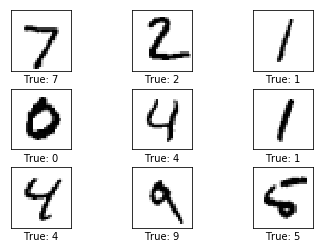

Instructions for updating:
Use the `axis` argument instead


In [2]:
%run data/shared_code.py

<div style="background-color:#0B8261; width:100%; height:38px; color:white; font-size:18px; padding:10px;" id="Convolutional-Neural-Net">
CONVOLUTIONAL NEURAL NETWORK
</div>

This section implements the Convolutional Neural Network using Pretty Tensor, which is much simpler than a direct implementation in TensorFlow, see Tutorial #03.

The basic idea is to wrap the input tensor `x_image` in a Pretty Tensor object which has helper-functions for adding new computational layers so as to create an entire neural network. Pretty Tensor takes care of the variable allocation, etc.

In [3]:
x_pretty = pt.wrap(x_image)

Now that we have wrapped the input image in a Pretty Tensor object, we can add the convolutional and fully-connected layers in just a few lines of source-code.

Note that `pt.defaults_scope(activation_fn=tf.nn.relu)` makes `activation_fn=tf.nn.relu` an argument for each of the layers constructed inside the `with`-block, so that Rectified Linear Units (ReLU) are used for each of these layers. The `defaults_scope` makes it easy to change arguments for all of the layers.

In [4]:
with pt.defaults_scope(activation_fn=tf.nn.relu):
    y_pred, loss = x_pretty.\
        conv2d(kernel=5, depth=16, name='layer_conv1').\
        max_pool(kernel=2, stride=2).\
        conv2d(kernel=5, depth=36, name='layer_conv2').\
        max_pool(kernel=2, stride=2).\
        flatten().\
        fully_connected(size=128, name='layer_fc1').\
        softmax_classifier(num_classes=num_classes, labels=y_true)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



<div style="background-color:#0B8261; width:100%; height:38px; color:white; font-size:18px; padding:10px;" id="Getting-Weights">
GETTING WEIGHTS
</div>

Further below, we want to plot the weights of the neural network. When the network is constructed using Pretty Tensor, all the variables of the layers are created indirectly by Pretty Tensor. We therefore have to retrieve the variables from TensorFlow.

We used the names `layer_conv1` and `layer_conv2` for the two convolutional layers. These are also called variable scopes (not to be confused with `defaults_scope` as described above). Pretty Tensor automatically gives names to the variables it creates for each layer, so we can retrieve the weights for a layer using the layer's scope-name and the variable-name.

The implementation is somewhat awkward because we have to use the TensorFlow function `get_variable()` which was designed for another purpose; either creating a new variable or re-using an existing variable. The easiest thing is to make the following helper-function.

In [5]:
def get_weights_variable(layer_name):
    # Retrieve an existing variable named 'weights' in the scope
    # with the given layer_name.
    # This is awkward because the TensorFlow function was
    # really intended for another purpose.

    with tf.variable_scope(layer_name, reuse=True):
        variable = tf.get_variable('weights')

    return variable

Using this helper-function we can retrieve the variables. These are TensorFlow objects. In order to get the contents of the variables, you must do something like: `contents = session.run(weights_conv1)` as demonstrated further below.

In [6]:
weights_conv1 = get_weights_variable(layer_name='layer_conv1')
weights_conv2 = get_weights_variable(layer_name='layer_conv2')

<div style="background-color:#0B8261; width:100%; height:38px; color:white; font-size:18px; padding:10px;" id="Optimization-Method">
OPTIMIZATION METHOD
</div>

Pretty Tensor gave us the predicted class-label (`y_pred`) as well as a loss-measure that must be minimized, so as to improve the ability of the neural network to classify the input images.

It is unclear from the documentation for Pretty Tensor whether the loss-measure is cross-entropy or something else. But we now use the `AdamOptimizer` to minimize the loss.

Note that optimization is not performed at this point. In fact, nothing is calculated at all, we just add the optimizer-object to the TensorFlow graph for later execution.

In [7]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)

<div style="background-color:#0B8261; width:100%; height:38px; color:white; font-size:18px; padding:10px;" id="Performance-Measures">
PERFORMANCE MEASURES
</div>

We need a few more performance measures to display the progress to the user.

First we calculate the predicted class number from the output of the neural network `y_pred`, which is a vector with 10 elements. The class number is the index of the largest element.

In [8]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

Then we create a vector of booleans telling us whether the predicted class equals the true class of each image.

In [9]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

The classification accuracy is calculated by first type-casting the vector of booleans to floats, so that False becomes 0 and True becomes 1, and then taking the average of these numbers.

In [10]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

<div style="background-color:#0B8261; width:100%; height:38px; color:white; font-size:18px; padding:10px;" id="Saver">
SAVER
</div>

In order to save the variables of the neural network, we now create a so-called Saver-object which is used for storing and retrieving all the variables of the TensorFlow graph. Nothing is actually saved at this point, which will be done further below in the `optimize()`-function.

In [11]:
saver = tf.train.Saver()

The saved files are often called checkpoints because they may be written at regular intervals during optimization.

This is the directory used for saving and retrieving the data.

In [12]:
save_dir = 'data/checkpoints/'

Create the directory if it does not exist.

In [13]:
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

This is the path for the checkpoint-file.

In [14]:
save_path = os.path.join(save_dir, 'best_validation')

<div style="background-color:#0B8261; width:100%; height:38px; color:white; font-size:18px; padding:10px;" id="TensorFlow-Run">
TENSORFLOW RUN
</div>

<h3 style="color:#45A046;">Create TensorFlow Session</h3>

Once the TensorFlow graph has been created, we have to create a TensorFlow session which is used to execute the graph.

In [15]:
session = tf.Session()

<h3 style="color:#45A046;">Initialize Variables</h3>

The variables for `weights` and `biases` must be initialized before we start optimizing them. We make a simple wrapper-function for this, because we will call it again below.

In [16]:
def init_variables():
    session.run(tf.global_variables_initializer())

Execute the function now to initialize the variables.

In [17]:
init_variables()

<h3 style="color:#45A046;">Helper-Function to Perform Optimization Iterations</h3>

There are 55,000 images in the training-set. It takes a long time to calculate the gradient of the model using all these images. We therefore only use a small batch of images in each iteration of the optimizer.

If your computer crashes or becomes very slow because you run out of RAM, then you may try and lower this number, but you may then need to perform more optimization iterations.

In [18]:
train_batch_size = 64

The classification accuracy for the validation-set will be calculated for every 100 iterations of the optimization function below. The optimization will be stopped if the validation accuracy has not been improved in 1000 iterations. We need a few variables to keep track of this.

In [19]:
# Best validation accuracy seen so far.
best_validation_accuracy = 0.0

# Iteration-number for last improvement to validation accuracy.
last_improvement = 0

# Stop optimization if no improvement found in this many iterations.
require_improvement = 1000

Function for performing a number of optimization iterations so as to gradually improve the variables of the network layers. In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples.  The progress is printed every 100 iterations where the validation accuracy is also calculated and saved to a file if it is an improvement.

In [20]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variables rather than local copies.
    global total_iterations
    global best_validation_accuracy
    global last_improvement

    # Start-time used for printing time-usage below.
    start_time = time.time()

    
    for i in range(num_iterations):

        # Increase the total number of iterations performed.
        # It is easier to update it in each iteration because
        # we need this number several times in the following.
        total_iterations += 1

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations and after last iteration.
        if (total_iterations % 100 == 0) or (i == num_iterations ):

            # Calculate the accuracy on the training-batch.
            acc_train = session.run(accuracy, feed_dict=feed_dict_train)

            # Calculate the accuracy on the validation-set.
            # The function returns 2 values but we only need the first.
            acc_validation, _ = validation_accuracy()

            # If validation accuracy is an improvement over best-known.
            if acc_validation > best_validation_accuracy:
                # Update the best-known validation accuracy.
                best_validation_accuracy = acc_validation
                
                # Set the iteration for the last improvement to current.
                last_improvement = total_iterations

                # Save all variables of the TensorFlow graph to file.
                saver.save(sess=session, save_path=save_path)

                # A string to be printed below, shows improvement found.
                improved_str = '*'
            else:
                # An empty string to be printed below.
                # Shows that no improvement was found.
                improved_str = ''
            
            # Status-message for printing.
            msg = "Iter: {0:>6}, Train-Batch Accuracy: {1:>6.1%}, Validation Acc: {2:>6.1%} {3}"

            # Print it.
            print(msg.format(i + 1, acc_train, acc_validation, improved_str))

        # If no improvement found in the required number of iterations.
        if total_iterations - last_improvement > require_improvement:
            print("No improvement found in a while, stopping optimization.")

            # Break out from the for-loop.
            break

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

<h3 style="color:#45A046;">Helper-Function to Plot Example Errors</span>

Function for plotting examples of images from the test-set that have been mis-classified.

In [21]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

<h3 style="color:#45A046;">Helper-Function to Plot Confusion Matrix</span>

In [22]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

<h3 style="color:#45A046;">Helper-Function for Calculating Classifications</h3>

This function calculates the predicted classes of images and also returns a boolean array whether the classification of each image is correct.

The calculation is done in batches because it might use too much RAM otherwise. If your computer crashes then you can try and lower the batch-size.

In [23]:
# Split the data-set in batches of this size to limit RAM usage.
batch_size = 256

def predict_cls(images, labels, cls_true):
    # Number of images.
    num_images = len(images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_images, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_images:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_images)

        # Create a feed-dict with the images and labels
        # between index i and j.
        feed_dict = {x: images[i:j, :],
                     y_true: labels[i:j, :]}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    return correct, cls_pred

Calculate the predicted class for the test-set.

In [24]:
def predict_cls_test():
    return predict_cls(images = data.test.images,
                       labels = data.test.labels,
                       cls_true = data.test.cls)

Calculate the predicted class for the validation-set.

In [25]:
def predict_cls_validation():
    return predict_cls(images = data.validation.images,
                       labels = data.validation.labels,
                       cls_true = data.validation.cls)

<h3 style="color:#45A046;">Helper-Function for the Classification Accuracy</h3>

This function calculates the classification accuracy given a boolean array whether each image was correctly classified. E.g. `cls_accuracy([True, True, False, False, False]) = 2/5 = 0.4`

In [26]:
def cls_accuracy(correct):
    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / len(correct)

    return acc, correct_sum

Calculate the classification accuracy on the validation-set.

In [27]:
def validation_accuracy():
    # Get the array of booleans whether the classifications are correct
    # for the validation-set.
    # The function returns two values but we only need the first.
    correct, _ = predict_cls_validation()
    
    # Calculate the classification accuracy and return it.
    return cls_accuracy(correct)

<h3 style="color:#45A046;">Helper-Function for Showing the Performance</h3>

Function for printing the classification accuracy on the test-set.

It takes a while to compute the classification for all the images in the test-set, that's why the results are re-used by calling the above functions directly from this function, so the classifications don't have to be recalculated by each function.

In [28]:
def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # For all the images in the test-set,
    # calculate the predicted classes and whether they are correct.
    correct, cls_pred = predict_cls_test()

    # Classification accuracy and the number of correct classifications.
    acc, num_correct = cls_accuracy(correct)
    
    # Number of images being classified.
    num_images = len(correct)

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

<h3 style="color:#45A046;">Helper-Function for Plotting Convolutional Weights</span>

In [29]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.

    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)

    # Print mean and standard deviation.
    print("Mean: {0:.5f}, Stdev: {1:.5f}".format(w.mean(), w.std()))
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # The format of this 4-dim tensor is determined by the
            # TensorFlow API. See Tutorial #02 for more details.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

<div style="background-color:#0B8261; width:100%; height:38px; color:white; font-size:18px; padding:10px;" id="Performance-over-Optimizations">
PERFORMANCE BEFORE OPTIMIZATIONS
</div>

The accuracy on the test-set is very low because the model variables have only been initialized and not optimized at all, so it just classifies the images randomly.

In [30]:
print_test_accuracy()

Accuracy on Test-Set: 11.7% (1165 / 10000)


The convolutional weights are random, but it can be difficult to see any difference from the optimized weights that are shown below. The mean and standard deviation is shown so we can see whether there is a difference.

Mean: 0.01327, Stdev: 0.27901


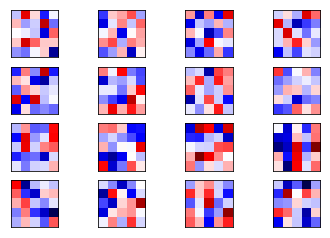

In [31]:
plot_conv_weights(weights=weights_conv1)

<div style="background-color:#0B8261; width:100%; height:38px; color:white; font-size:18px; padding:10px;">
PERFORMANCE AFTER 10,000 OPTIMIZATION ITERATIONS
</div>

We now perform 10,000 optimization iterations and abort the optimization if no improvement is found on the validation-set in 1000 iterations.

An asterisk * is shown if the classification accuracy on the validation-set is an improvement.

!! You may need to pause cloud synchronization if your files are stored in OneDrive/Google-Drive/Dropbox/etc !!

In [32]:
optimize(num_iterations=10000)

Iter:    100, Train-Batch Accuracy:  82.8%, Validation Acc:  84.6% *
Iter:    200, Train-Batch Accuracy:  90.6%, Validation Acc:  91.5% *
Iter:    300, Train-Batch Accuracy:  87.5%, Validation Acc:  93.5% *
Iter:    400, Train-Batch Accuracy:  95.3%, Validation Acc:  94.5% *
Iter:    500, Train-Batch Accuracy:  95.3%, Validation Acc:  95.3% *
Iter:    600, Train-Batch Accuracy:  96.9%, Validation Acc:  95.4% *
Iter:    700, Train-Batch Accuracy:  93.8%, Validation Acc:  95.8% *
Iter:    800, Train-Batch Accuracy:  98.4%, Validation Acc:  96.4% *
Iter:    900, Train-Batch Accuracy:  96.9%, Validation Acc:  96.3% 
Iter:   1000, Train-Batch Accuracy:  96.9%, Validation Acc:  96.6% *
Iter:   1100, Train-Batch Accuracy:  98.4%, Validation Acc:  96.6% 
Iter:   1200, Train-Batch Accuracy:  96.9%, Validation Acc:  96.9% *
Iter:   1300, Train-Batch Accuracy:  96.9%, Validation Acc:  97.2% *
Iter:   1400, Train-Batch Accuracy:  96.9%, Validation Acc:  97.2% *
Iter:   1500, Train-Batch Accuracy: 

Accuracy on Test-Set: 98.7% (9872 / 10000)
Example errors:


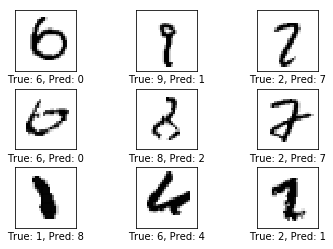

Confusion Matrix:
[[ 970    0    0    0    0    3    2    2    2    1]
 [   0 1127    2    1    0    0    1    1    3    0]
 [   2    2 1006    2    1    0    0   11    8    0]
 [   1    0    0 1004    0    1    0    2    2    0]
 [   0    0    0    1  976    0    0    1    1    3]
 [   2    0    0    3    0  885    1    1    0    0]
 [   5    2    0    0    3    5  939    0    4    0]
 [   0    1    1    1    1    0    0 1021    1    2]
 [   2    0    3    2    1    1    0    3  959    3]
 [   0    5    0    5    6    2    0    5    1  985]]


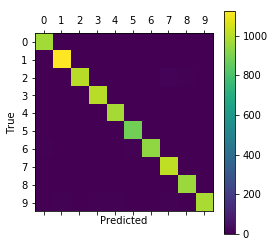

In [33]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

The convolutional weights have now been optimized. Compare these to the random weights shown above. They appear to be almost identical. In fact, I first thought there was a bug in the program because the weights look identical before and after optimization.

But try and save the images and compare them side-by-side (you can just right-click the image to save it). You will notice very small differences before and after optimization.

The mean and standard deviation has also changed slightly, so the optimized weights must be different.

Mean: 0.03328, Stdev: 0.29066


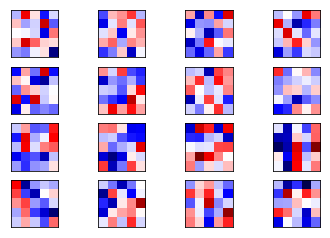

In [34]:
plot_conv_weights(weights=weights_conv1)

<div style="background-color:#0B8261; width:100%; height:38px; color:white; font-size:18px; padding:10px;" id="Initialize-Variables-Again">
INITIALIZE VARIABLES AGAIN
</div>

Re-initialize all the variables of the neural network with random values.

In [35]:
init_variables()

This means the neural network classifies the images completely randomly again, so the classification accuracy is very poor because it is like random guesses.

In [36]:
print_test_accuracy()

Accuracy on Test-Set: 12.6% (1262 / 10000)


The convolutional weights should now be different from the weights shown above.

Mean: -0.00370, Stdev: 0.26247


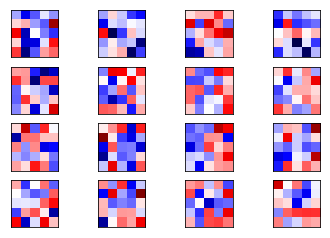

In [37]:
plot_conv_weights(weights=weights_conv1)

<div style="background-color:#0B8261; width:100%; height:38px; color:white; font-size:18px; padding:10px;" id="Restore-Best-Variables">
RESTORE BEST VARIABLES
</div>

Re-load all the variables that were saved to file during optimization.

In [38]:
saver.restore(sess=session, save_path=save_path)

INFO:tensorflow:Restoring parameters from data/checkpoints/best_validation


The classification accuracy is high again when using the variables that were previously saved.

Note that the classification accuracy may be slightly higher or lower than that reported above, because the variables in the file were chosen to maximize the classification accuracy on the validation-set, but the optimization actually continued for another 1000 iterations after saving those variables, so we are reporting the results for two slightly different sets of variables. Sometimes this leads to slightly better or worse performance on the test-set.

Accuracy on Test-Set: 98.6% (9855 / 10000)
Example errors:


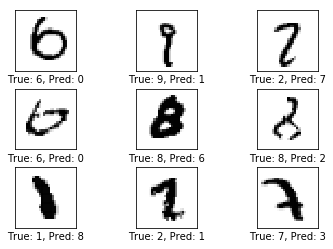

Confusion Matrix:
[[ 975    0    0    0    0    0    2    1    2    0]
 [   0 1128    3    0    0    0    3    0    1    0]
 [   3    1 1019    1    3    0    0    2    3    0]
 [   1    0    0 1002    0    4    0    1    2    0]
 [   0    0    1    1  976    0    0    0    3    1]
 [   2    0    0    2    0  887    1    0    0    0]
 [   5    2    0    0    2    3  943    0    3    0]
 [   1    4   15    3    1    0    0  999    3    2]
 [   4    1    4    2    1    1    2    2  955    2]
 [   4    7    1    7   10    3    0    4    2  971]]


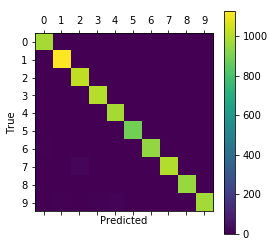

In [39]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

The convolutional weights should be nearly identical to those shown above, although not completely identical because the weights shown above had 1000 optimization iterations more.

Mean: 0.03210, Stdev: 0.28946


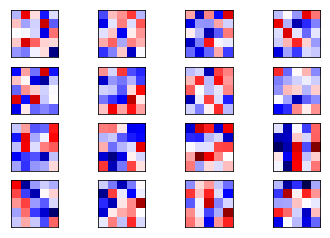

In [40]:
plot_conv_weights(weights=weights_conv1)

<h3 style="color:#45A046;">Close TensorFlow Session</h3>

We are now done using TensorFlow, so we close the session to release its resources.

In [41]:
# This can be commented out in case you want to modify and experiment
# with the Notebook without having to restart it.
session.close()

<div style="background-color:#0B8261; width:100%; height:38px; color:white; font-size:18px; padding:10px;" id="Summary">
SUMMARY
</div>

This tutorial showed how to save and retrieve the variables of a neural network in TensorFlow. This can be used in different ways. For example, if you want to use a neural network for recognizing images then you only have to train the network once and you can then deploy the finished network on other computers.

Another use of checkpoints is if you have a very large neural network and data-set, then you may want to save checkpoints at regular intervals in case the computer crashes, so you can continue the optimization at a recent checkpoint instead of having to restart the optimization from the beginning.

This tutorial also showed how to use the validation-set for so-called Early Stopping, where the optimization was aborted if it did not regularly improve the validation error. This is useful if the neural network starts to overfit and learn the noise of the training-set; although it was not really an issue with the convolutional network and MNIST data-set used in this tutorial.

An interesting observation was that the convolutional weights (or filters) changed very little from the optimization, even though the performance of the network went from random guesses to near-perfect classification. It seems strange that the random weights were almost good enough. Why do you think this happens?

<div style="background-color:#0B8261; width:100%; height:38px; color:white; font-size:18px; padding:10px;" id="Challenge">
CHALLENGE
</div>

These are a few suggestions for exercises that may help improve your skills with TensorFlow. It is important to get hands-on experience with TensorFlow in order to learn how to use it properly.

You may want to backup this Notebook before making any changes.

* Optimization is stopped after 1000 iterations without improvement. Is this enough? Can you think of a better way to do Early Stopping? Try and implement it.
* If the checkpoint file already exists then load it instead of doing the optimization.
* Save a new checkpoint for every 100 optimization iterations. Retrieve the latest using `saver.latest_checkpoint()`. Why would you want to save multiple checkpionts instead of just the most recent?
* Try and change the neural network, e.g. by adding another layer. What happens when you reload the variables from a different network?
* Plot the weights for the 2nd convolutional layer before and after optimization using the function `plot_conv_weights()`. Are they almost identical as well?
* Why do you think the optimized convolutional weights are almost the same as the random initialization?
* Remake the program yourself without looking too much at this source-code.
* Explain to a friend how the program works.

<div style="background-color:#0B8261; width:100%; height:38px; color:white; font-size:18px; padding:10px;">
LICENSE (MIT)
</div>

Copyright (c) 2016 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.